# Meta-population population flux library
## cv19mobility

In [11]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
from cv19gm.utils import cv19mobility

In [6]:
population = [1000,5000,8000,15000,20000]

In [7]:
mobility = cv19mobility.rnd_flux_symmetric(population=population)

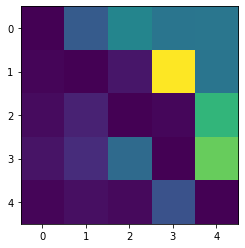

In [13]:
plt.imshow(mobility(0.5))

In [52]:
def export(mobfunction,t=None,path=None):
    aux = {}
    if not t:
        t = np.arange(0,2,0.5)
    for i in t:
        aux[i] = mobfunction(i).tolist()
    if path:
        json.dump(aux,path)
    return json.dumps(aux)    

In [53]:
a = export(mobility)

In [54]:
json.dump()

'{"0.0": [[0, 12, 27, 46, 13], [258, 0, 87, 115, 38], [410, 54, 0, 312, 22], [350, 904, 17, 0, 227], [356, 353, 594, 694, 0]], "0.5": [[0, 258, 410, 350, 356], [12, 0, 54, 904, 353], [27, 87, 0, 17, 594], [46, 115, 312, 0, 694], [13, 38, 22, 227, 0]], "1.0": [[0, 12, 27, 46, 13], [258, 0, 87, 115, 38], [410, 54, 0, 312, 22], [350, 904, 17, 0, 227], [356, 353, 594, 694, 0]], "1.5": [[0, 258, 410, 350, 356], [12, 0, 54, 904, 353], [27, 87, 0, 17, 594], [46, 115, 312, 0, 694], [13, 38, 22, 227, 0]]}'

In [43]:
str(a[0])

'[[  0  12  27  46  13]\n [258   0  87 115  38]\n [410  54   0 312  22]\n [350 904  17   0 227]\n [356 353 594 694   0]]'

In [44]:
def import_mobility(mobfunction,path=None):
    aux = {}
    if not t:
        t = np.arange(0,2,0.5)
    for i in t:
        aux[i] = mobfunction(i).tolist()
    if path:
        json.dump(aux,path)
    return json.dumps(aux)

TypeError: Object of type ndarray is not JSON serializable

In [25]:
json.dumps(a)

TypeError: Object of type ndarray is not JSON serializable